# **STAT 5010 Project: H & M Recommender Systems**
## **Aravindh Saravanan**
#### 04/21/2022

## **Foreword**
For STAT 5010, I've enrolled into the following Kaggle Competition which involves Recommender Systems.

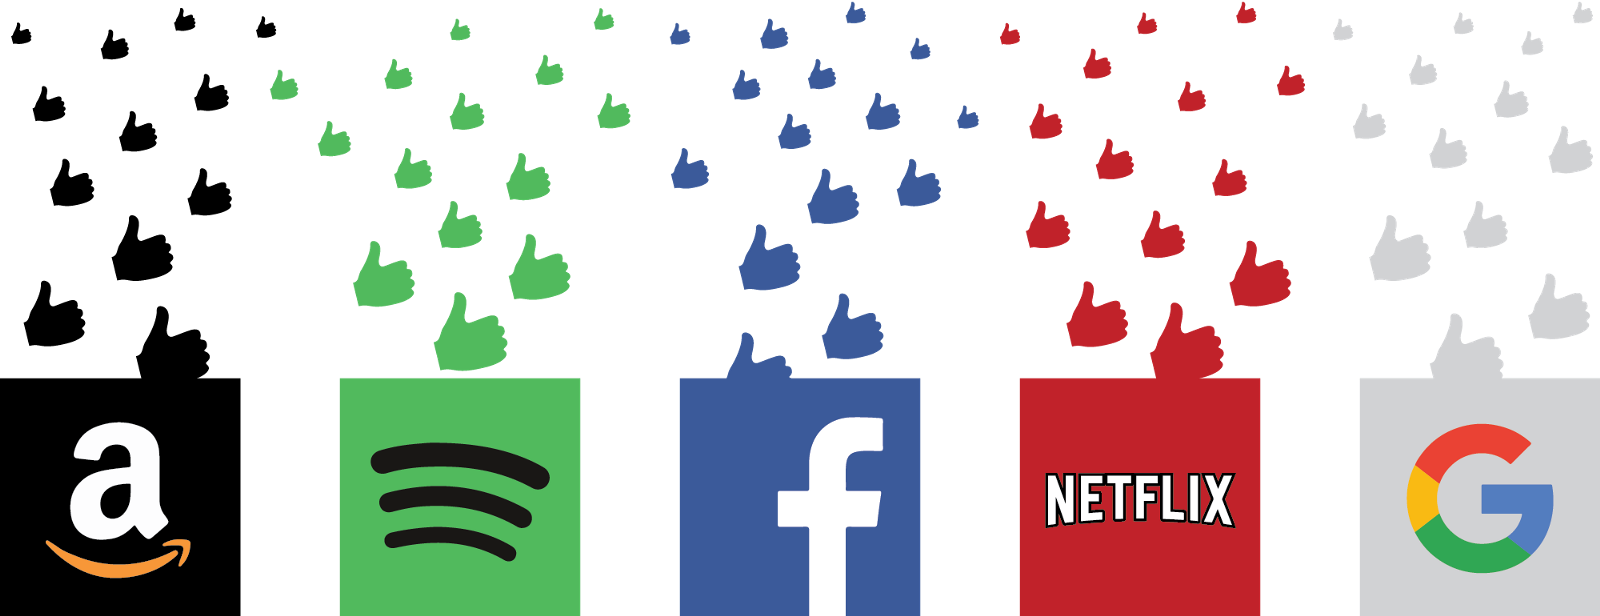

[Competition Link](https://https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/)

*From Kaggle:*

*H&M Group is a family of brands and businesses with 53 online markets and approximately 4,850 stores. Our online store offers shoppers an extensive selection of products to browse through. But with too many choices, customers might not quickly find what interests them or what they are looking for, and ultimately, they might not make a purchase. To enhance the shopping experience, product recommendations are key. More importantly, helping customers make the right choices also has a positive implications for sustainability, as it reduces returns, and thereby minimizes emissions from transportation.*

**I've explored several techniques involving Data Mining principles and conventional Recommender Systems and this notebook showcases my approach, results (though not entirely satisfactory) and more importantly what I have learnt. In the end I've also provided the results of my submission to Kaggle.**

## **Contents**
1. About the Dataset
2. Importing Packages, Setting up the environment, loading the dataset
3. Exploratory Data Analysis (EDA)
4. Data-Preprocessing
5. Frequent itemsets generation (RAPIDS)
6. Building a Recommender System
7. Results, Findings
8. Conclusion, Future Work
9. Backstage (Other approaches tried)
10. References


## **1. About the Dataset**

In this competition, H&M Group wants to develop product recommendations based on data from previous transactions, as well as from customer and product meta data. The available meta data spans from simple data, such as garment type and customer age, to text data from product descriptions, to image data from garment images.
There are 3 files and 1 library consisting of images for all products.
* articles.csv - detailed metadata for each article_id available for purchase
* customers.csv - metadata for each customer_id in dataset
* transactions_train.csv - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item

Output file is expected to consist of all the customer_ids and 12 predictions for each customer.


## **2. Importing Packages, Setting up the environment, loading the dataset**

In [2]:
#Implicit is for ALS
!pip install --upgrade implicit

     |████████████████████████████████| 18.5 MB 437 kB/s 


In [3]:
!pip install pyspark -q

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 48.8 MB/s 


In [4]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from sklearn.cluster import KMeans
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os; os.environ['OPENBLAS_NUM_THREADS']='1'
import implicit
from scipy.sparse import coo_matrix
from implicit.evaluation import mean_average_precision_at_k

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We will upload the Kaggle.JSON file which enables us to connect our notebook directly to kaggle and download all the necessary datasets. This process takes a while (~30min).

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aravindhsaravanan","key":"6134d9462ea19f92b200f2739c66a262"}'}

In [6]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations

100% 28.7G/28.7G [03:14<00:00, 177MB/s]
100% 28.7G/28.7G [03:14<00:00, 158MB/s]


In [9]:
! mkdir train_C
#! unzip h-and-m-personalized-fashion-recommendations.zip -d train
import zipfile
from zipfile import ZipFile
with ZipFile('h-and-m-personalized-fashion-recommendations.zip', 'r') as zipObj:
    # Get a list of all archived file names from the zip
    listOfFileNames = zipObj.namelist()
    # Iterate over the file names
    for fileName in listOfFileNames:
        #check the excluding file condition.
        if fileName in ('transactions_train.csv','customers.csv','articles.csv', 'sample_submission.csv'):
            zipObj.extract(fileName, 'train_C/')
        continue

The data has been downloaded and unzipped. It is now ready to be read into dataframes.

In [10]:
articles = pd.read_csv('train_C/articles.csv')
#articles.head(5)
customers = pd.read_csv('train_C/customers.csv')
#customers.head(5)
transactions_train = pd.read_csv('train_C/transactions_train.csv')
#transactions.head(5)

We have not read the images as the text data has a lot of features which should be sufficient to build our recommendations.

## **3. Exploratory Data Analysis (EDA)**

EDA of our dataset enables us to better understand the features(predictors) and uncover relationships between features. It could also help us identify data issues like missing values, outliers. We will start with basic exploration first and advance to graphical analysis.

We have 3 data tables - Articles, Customers & Transactions. We will look at them one by one.

1. Articles

In [11]:
articles.head(1)

article_id  product_code  prod_name  product_type_no product_type_name  \
0   108775015        108775  Strap top              253          Vest top   

   product_group_name  graphical_appearance_no graphical_appearance_name  \
0  Garment Upper body                  1010016                     Solid   

   colour_group_code colour_group_name  ...  department_name index_code  \
0                  9             Black  ...     Jersey Basic          A   

   index_name index_group_no  index_group_name section_no  \
0  Ladieswear              1        Ladieswear         16   

             section_name garment_group_no  garment_group_name  \
0  Womens Everyday Basics             1002        Jersey Basic   

                               detail_desc  
0  Jersey top with narrow shoulder straps.  

[1 rows x 25 columns]

In [12]:
articles.dtypes

article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

In [13]:
#checking for duplicates.
articles[articles.duplicated()]

Empty DataFrame
Columns: [article_id, product_code, prod_name, product_type_no, product_type_name, product_group_name, graphical_appearance_no, graphical_appearance_name, colour_group_code, colour_group_name, perceived_colour_value_id, perceived_colour_value_name, perceived_colour_master_id, perceived_colour_master_name, department_no, department_name, index_code, index_name, index_group_no, index_group_name, section_no, section_name, garment_group_no, garment_group_name, detail_desc]
Index: []

[0 rows x 25 columns]

In [14]:
#checking for missing values
print(articles.isnull().sum())

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64


As a first visual, let us look at what type of articles are available in H & M.

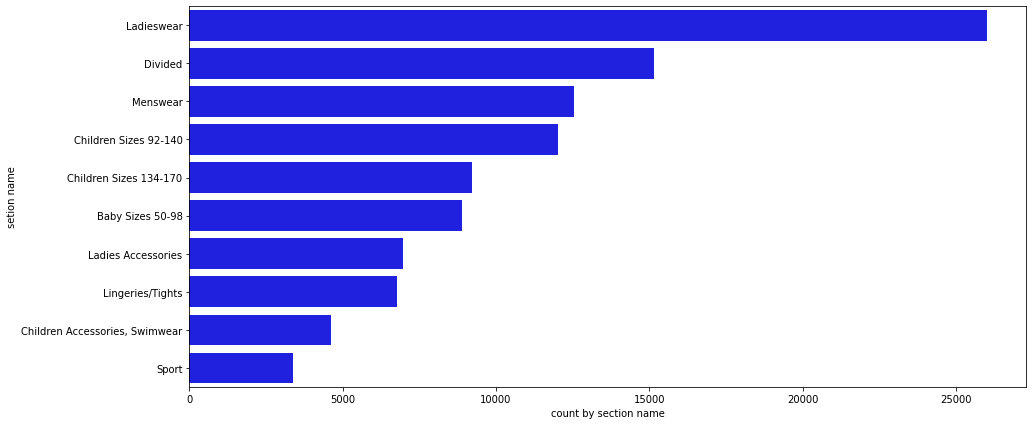

In [38]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.countplot(data=articles, y='index_name', color='blue', order=articles.index_name.value_counts().iloc[:30].index)
ax.set_xlabel('count by section name')
ax.set_ylabel('setion name')
plt.show()

This tells us that Ladieswear has the most number of items and almost twice the collection of men's. That is, the diversity is more for ladies here. (does not mean it is sold more)

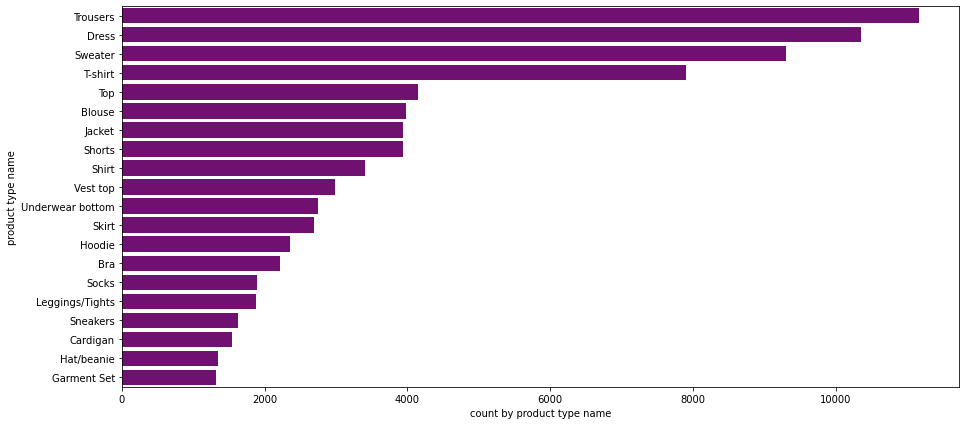

In [27]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.countplot(data=articles, y='product_type_name', color='purple', order=articles.product_type_name.value_counts().iloc[:20].index)
ax.set_xlabel('count by product type name')
ax.set_ylabel('product type name')
plt.show()

The above chart adds 1 more level of granularity to the previous one and tells us that trousers have the most number of items.

2. Transactions

In [39]:
transactions_train.head(1)

t_dat                                        customer_id  article_id  \
0  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   

      price  sales_channel_id  
0  0.050831                 2

In [40]:
transactions_train.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [41]:
transactions_train.shape

(31788324, 5)

In [42]:
transactions_train[transactions_train.duplicated()]

t_dat                                        customer_id  \
15        2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   
18        2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   
20        2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   
21        2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   
22        2018-09-20  000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...   
...              ...                                                ...   
31788268  2020-09-22  ff54fe15368409b7d0d691cdeebe2d6a3fee5178105277...   
31788269  2020-09-22  ff54fe15368409b7d0d691cdeebe2d6a3fee5178105277...   
31788282  2020-09-22  ff6f55a51af284b71dcd264396b299e548f968c1769e71...   
31788292  2020-09-22  ff94f31e864d9b655643ac4d2adab3611c7241adb5d34c...   
31788312  2020-09-22  ffd4cf2217de4a0a3f9f610cdec334c803692a18af08ac...   

          article_id     price  sales_channel_id  
15         501820043  0.016932                 2  
18         671505001  0.033881                 2  
20         631848002  0.033881                 2  
21         631848002  0.033881                 2  
22         631848002  0.033881                 2  
...              ...       ...               ...  
31788268   885315003  0.050102                 2  
31788269   885315003  0.050102                 2  
31788282   919786002  0.042356                 2  
31788292   901666001  0.084729                 2  
31788312   791587021  0.025407                 2  

[2974905 rows x 5 columns]

Duplicate transactions here mean that the same item has been purchased multiple times. This is also because each row here belongs to a customer.

3. Customers

In [43]:
customers.head(1)

customer_id  FN  Active  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3... NaN     NaN   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  49.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...

In [45]:
customers.shape

(1371980, 7)

In [46]:
customers.dtypes

customer_id                object
FN                        float64
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

In [47]:
customers[customers.duplicated()]

Empty DataFrame
Columns: [customer_id, FN, Active, club_member_status, fashion_news_frequency, age, postal_code]
Index: []

## **4. Data-Preprocessing**

Before further exploration, it would be more useful to combine the datasets together. We will proceed with combining the 3 dataframes, performing cleaning and then continue with Exploratory Data Analysis.

Merging Articles, Customers & Transaction

In [48]:
transactions = transactions_train.groupby(['t_dat','customer_id','article_id','price','sales_channel_id'],as_index=False).size()

It is a good practice to clean up memory to make sure unused variables are removed. Not doing so every now and then would result in the system crashing.

In [51]:
# Calling Garbage Collector to cleanup memory
import gc
del transactions_train
gc.collect()

66

We will combine the 3 dataframes using the following approach:

**Transactions_train** ==(Left Join)==> [**Articles** ==(Join)==> **Customers**]

In [52]:
temp = pd.merge(transactions,articles,how='left',on='article_id')
data_merged = pd.merge(temp,customers,how='left',on='customer_id')
data_merged.shape

(28813419, 36)

In [53]:
data_merged.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'size', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'postal_code'],
      dtype='object')

In [ ]:
data_final = data_merged.drop(['t_dat','customer_id','prod_name','product_type_name','product_group_name','graphical_appearance_name','colour_group_name','perceived_colour_value_name','perceived_colour_master_name','department_name','index_name','index_group_name','section_name','garment_group_name','detail_desc','postal_code'],axis=1)

In [ ]:
data_final = data_final.reset_index(drop=True)
data_final.shape

In [ ]:
data_final_t = data_final_t.reset_index(drop=True)
#data_final = data_final.drop(['Unnamed: 0'],axis=1)
data_final_t.shape

(28813419, 13)

In [ ]:
data_final = data_final_t.sample(frac=0.05)
data_final.shape

(1440671, 23)

In [ ]:
gc.collect()

88

#### Let us clean the dataset

In [ ]:
data_final.dtypes

t_dat                            object
customer_id                      object
article_id                        int64
price                           float64
size                              int64
prod_name                        object
product_type_name                object
product_group_name               object
graphical_appearance_name        object
colour_group_name                object
perceived_colour_value_name      object
perceived_colour_master_name     object
department_name                  object
index_name                       object
index_group_name                 object
section_name                     object
garment_group_name               object
FN                              float64
Active                          float64
club_member_status               object
fashion_news_frequency           object
age                             float64
postal_code                      object
dtype: object

index_code, club_member_status, fashion_news_frequency need to be converted to numerical formats (INT).

In [ ]:
data_final['index_code'].value_counts()

In [ ]:
data_final['club_member_status'].value_counts()

ACTIVE        1408779
PRE-CREATE      28745
LEFT CLUB         365
Name: club_member_status, dtype: int64

In [ ]:
data_final['fashion_news_frequency'].value_counts()

NONE         814744
Regularly    619010
Monthly         506
Name: fashion_news_frequency, dtype: int64

#### Replace Values

In [ ]:
data_final['fashion_news_frequency'] = data_final['fashion_news_frequency'].replace(['None'],'NONE')
data_final['fashion_news_frequency'].value_counts()

NONE         814744
Regularly    619010
Monthly         506
Name: fashion_news_frequency, dtype: int64

In [ ]:
data_final.isnull().sum()

t_dat                                0
customer_id                          0
article_id                           0
price                                0
size                                 0
prod_name                            0
product_type_name                    0
product_group_name                   0
graphical_appearance_name            0
colour_group_name                    0
perceived_colour_value_name          0
perceived_colour_master_name         0
department_name                      0
index_name                           0
index_group_name                     0
section_name                         0
garment_group_name                   0
FN                              822995
Active                          832376
club_member_status                2782
fashion_news_frequency            6411
age                               6425
postal_code                          0
dtype: int64

We see a lot of null values here. Dealing with these values might be not ideal even if we impute the data. The best approach would be to drop the variables wherever missing values is a lot.

In [ ]:
data_final['FN'].value_counts()

1.0    617676
Name: FN, dtype: int64

In [ ]:
data_final['club_member_status'].value_counts()

ACTIVE        1408779
PRE-CREATE      28745
LEFT CLUB         365
Name: club_member_status, dtype: int64

In [ ]:
data_final['fashion_news_frequency'].value_counts()

NONE         814744
Regularly    619010
Monthly         506
Name: fashion_news_frequency, dtype: int64

In [ ]:
data_final['FN']=data_final['FN'].fillna(0)
data_final['Active']=data_final['Active'].fillna(0)

In [ ]:
data_final['age']=data_final['age'].fillna(data_final['age'].mean(),inplace=False)
#data_final['club_member_status']=data_final['club_member_status'].fillna(data_final['club_member_status'].mode(),inplace=False)
#data_final['fashion_news_frequency']=data_final['fashion_news_frequency'].fillna(data_final['fashion_news_frequency'].mean(),inplace=False)
data_final=data_final.drop(['club_member_status','fashion_news_frequency'],axis=1)

In [ ]:
data_final.isnull().sum()

t_dat                           0
customer_id                     0
article_id                      0
price                           0
size                            0
prod_name                       0
product_type_name               0
product_group_name              0
graphical_appearance_name       0
colour_group_name               0
perceived_colour_value_name     0
perceived_colour_master_name    0
department_name                 0
index_name                      0
index_group_name                0
section_name                    0
garment_group_name              0
FN                              0
Active                          0
age                             0
postal_code                     0
dtype: int64

### EDA and Cleaning

We will look at how variables are distributed and then do some cleaning. This cleaning is mean to deal with outliers.

Let us look at Age first

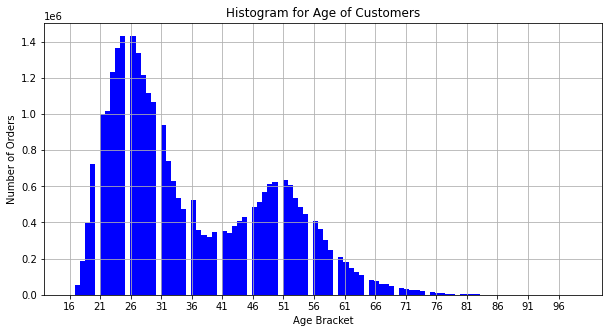

In [ ]:
ax = data_prep1['age'].hist(bins = 100, color = 'blue', figsize = (10, 5))
ax.set_title('Histogram for Age of Customers')
ax.set_xlabel('Age Bracket', fontsize = 10)
ax.set_ylabel('Number of Orders', fontsize = 10)
plt.xticks(np.arange(min(data_prep1['age']), max(data_prep1['age']), 5.0))
plt.tick_params(labelsize = 10)

We will keep Age as it is for now without binning and later modify if necessary

In [ ]:
ax = sns.boxplot(data=data_final['age'], orient="h", palette="Set3")

In [ ]:
Q1=data_prep1['age'].quantile(0.25)
Q3=data_prep1['age'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
Lower_Whisker = Q1-(1.5*IQR)
Upper_Whisker = Q3+(1.5*IQR)
print(Lower_Whisker, Upper_Whisker)

25.0
47.0
22.0
-8.0 80.0


Statistically any age above 80 could be an outlier. We proceed to treat these values.

In [ ]:
data_prep1['age']=np.where(data_prep1['age']>Upper_Whisker,Upper_Whisker,data_prep1['age'])

We have capped the age to 80. Taking a look at out boxplot again, we see clean data.

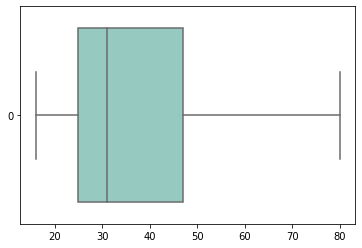

In [ ]:
ax = sns.boxplot(data=data_prep1['age'], orient="h", palette="Set3")

Price

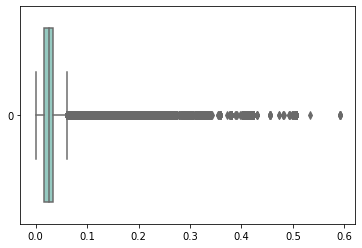

In [ ]:
ax = sns.boxplot(data=data_prep1['price'], orient="h", palette="Set3")

In [ ]:
Q1=data_prep1['price'].quantile(0.25)
Q3=data_prep1['price'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
Lower_Whisker = Q1-(1.5*IQR)
Upper_Whisker = Q3+(1.5*IQR)
print(Lower_Whisker, Upper_Whisker)

0.0156779661016949
0.0338813559322033
0.018203389830508402
-0.011627118644067704 0.06118644067796591


In [ ]:
data_prep1['price']=np.where(data_prep1['price']>Upper_Whisker,Upper_Whisker,data_prep1['price'])

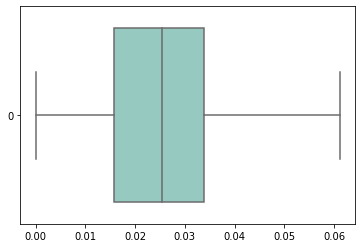

In [ ]:
ax = sns.boxplot(data=data_prep1['price'], orient="h", palette="Set3")

We have done some cleaning and our dataset now looks satisfactory. We can proceed with some advanced exploration.

##### Correlation Matrix

Let us check to see if there is any reasonable correlation between all our variables. If two variables are highly correlated, we can remove one of them.

In [ ]:
data_corr = data_prep1.corr().abs()

In [ ]:
data_corr.style.background_gradient(cmap='coolwarm')

Though the above correlation plot  portrays a lot of useful information about variable pairs, it is a bit clunky. Let us make the above plot easily interpretable.

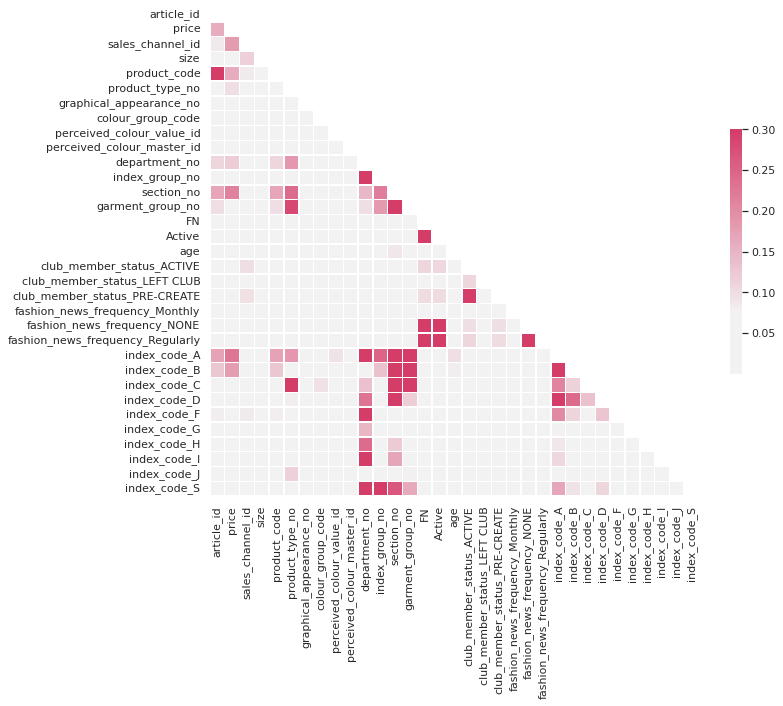

In [ ]:
sns.set_theme(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 0, sep=64, n=256, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Now, we can clearly see the pairs of variables that are correlated. We will proceed to drop these columns.

In [ ]:
upper = data_corr.where(np.triu(np.ones(data_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['product_code', 'Active', 'club_member_status_PRE-CREATE', 'fashion_news_frequency_NONE', 'fashion_news_frequency_Regularly', 'index_code_S']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [ ]:
data_prep2 = data_prep1.drop(data_prep1[to_drop], axis=1)

In [ ]:
data_prep1.shape

(28813419, 33)

In [ ]:
data_prep2.shape

(28813419, 27)

## **5. Frequent itemsets generation (RAPIDS)**

[RAPIDS](https://rapids.ai/start.html)  is a framework built by NVIDIA that uses GPU power to run Data Science Programs. They claim it cuts down running time from days to minutes. We will use this to generate frequent itemset pairs. This would help us identify buying patterns and hopefully help us decide if this would be suitable for the model.

Link: https://colab.research.google.com/drive/1TAAi_szMfWqRfHVfjGSqnGVLr_ztzUM9#scrollTo=G_2dancFhf70

#### The below blocks of code include setup of RAPIDS. Takes aprrox 20min to run and will intentionally crash Colab 2-3 times.

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 300 (delta 74), reused 99 (delta 55), pack-reused 171
Receiving objects: 100% (300/300), 87.58 KiB | 7.30 MiB/s, done.
Resolving deltas: 100% (136/136), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla P100-PCIE-16GB!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,496 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRe

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
done

## Package Plan ##

 

#### We've setup RAPIDS successfully. Let's run our algorithms now

#### Download data files from Kaggle

This step is necessary to improve memory performance. Ideally, the below section should be run in a different notebook altogether.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aravindhsaravanan","key":"6134d9462ea19f92b200f2739c66a262"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations
! mkdir train

100% 28.7G/28.7G [02:02<00:00, 292MB/s]
100% 28.7G/28.7G [02:02<00:00, 251MB/s]


In [ ]:
import zipfile
from zipfile import ZipFile
with ZipFile('h-and-m-personalized-fashion-recommendations.zip', 'r') as zipObj:
    # Get a list of all archived file names from the zip
    listOfFileNames = zipObj.namelist()
    # Iterate over the file names
    for fileName in listOfFileNames:
            zipObj.extract(fileName, 'train_C/')

#### Importing necessary Libraries

In [ ]:
import cudf, gc
import cv2, matplotlib.pyplot as plt
from os.path import exists
print('RAPIDS version',cudf.__version__)

RAPIDS version 21.12.02


#### Data Preprocessing for RAPIDS

Let's store for each customer the articles they have purchased in a single transaction as rows in our dataframe 

In [ ]:
df = cudf.read_csv('train_C/transactions_train.csv')
df = df[['customer_id','article_id']]
df.customer_id = df.customer_id.str[-16:].str.hex_to_int().astype('int64')
df.article_id = df.article_id.astype('int32')
_ = gc.collect()
print('Transactions shape',df.shape)
display(df.head())

Transactions shape (31788324, 2)


customer_id  article_id
0    -6846340800584936   663713001
1    -6846340800584936   541518023
2 -8334631767138808638   505221004
3 -8334631767138808638   685687003
4 -8334631767138808638   685687004

In [ ]:
cnts = df.article_id.value_counts()
cnts.head(10)

706016001    50287
706016002    35043
372860001    31718
610776002    30199
759871002    26329
464297007    25025
372860002    24458
610776001    22451
399223001    22236
706016003    21241
Name: article_id, dtype: int32

In [ ]:
pairs = {}
for j,i in enumerate(cnts.index.values[500:540]):
    custs = df.loc[df.article_id==i.item(),'customer_id'].unique()
    items = df.loc[(df.customer_id.isin(custs))&(df.article_id!=i.item()),'article_id'].value_counts()
    pairs[i.item()] = [items.index[0], items.index[1], items.index[2], items.index[3], items.index[4], items.index[5], items.index[6], items.index[7]]

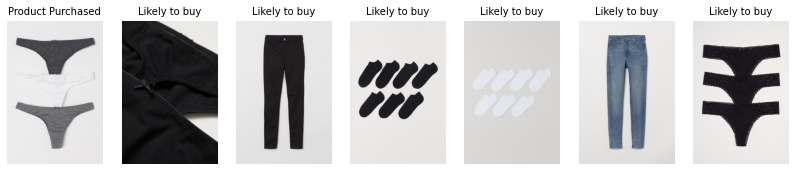

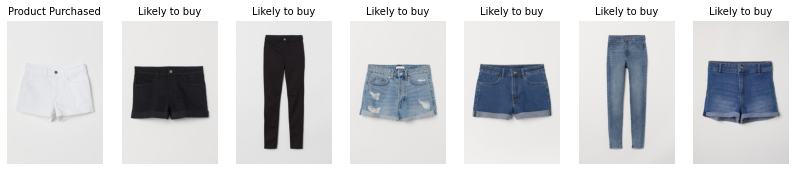

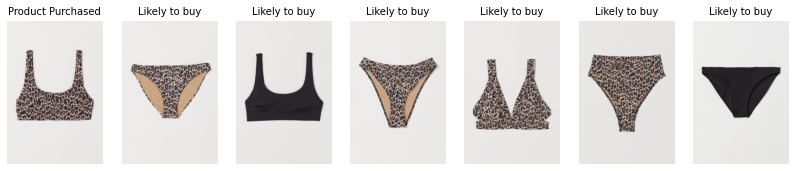

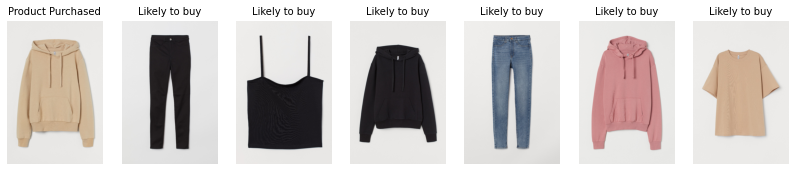

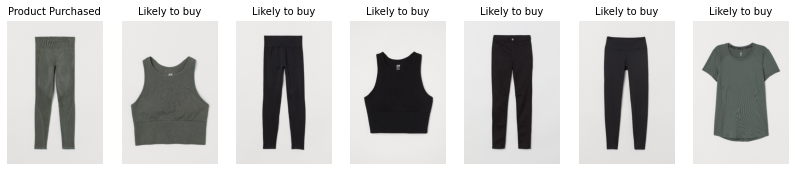

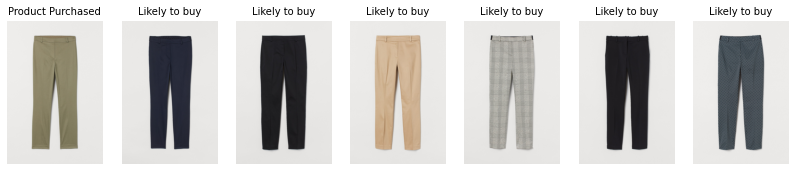

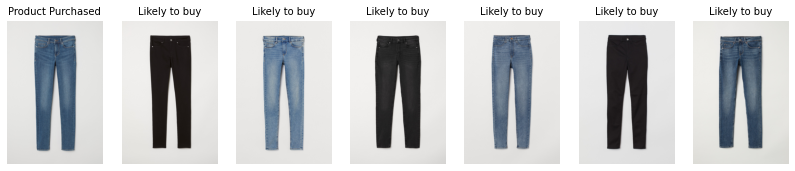

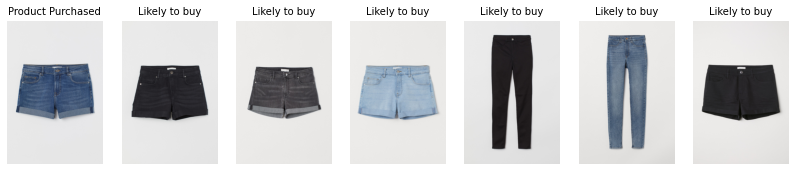

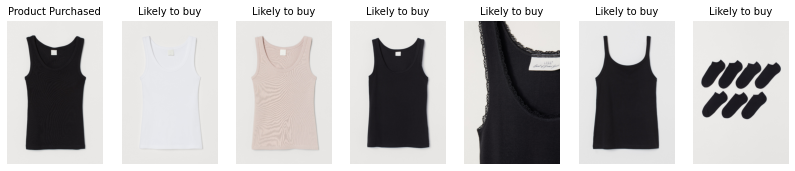

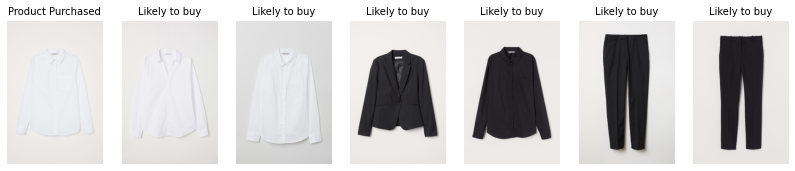

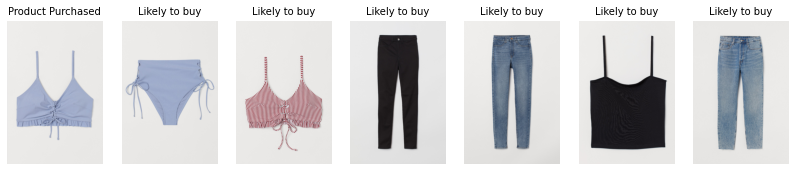

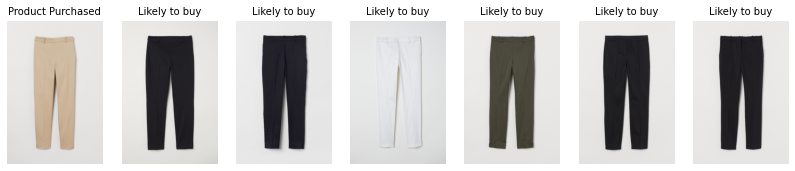

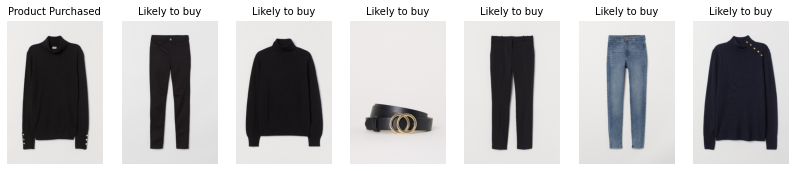

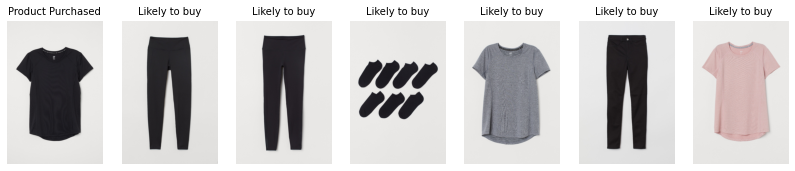

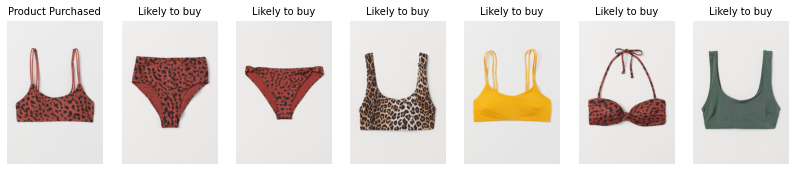

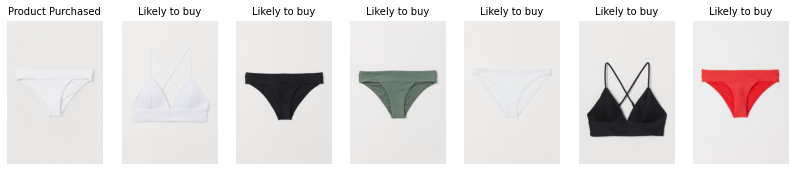

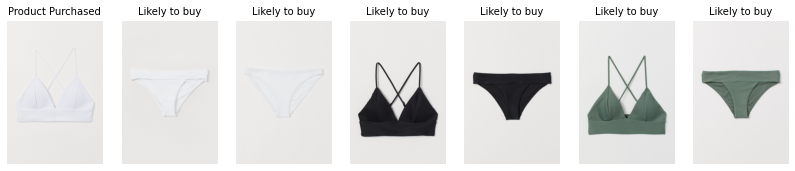

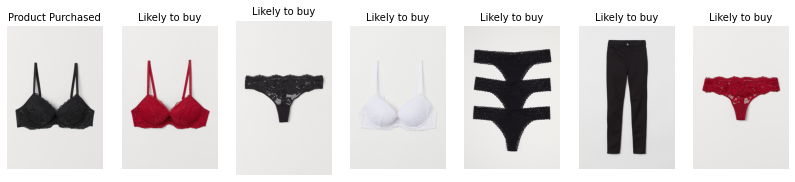

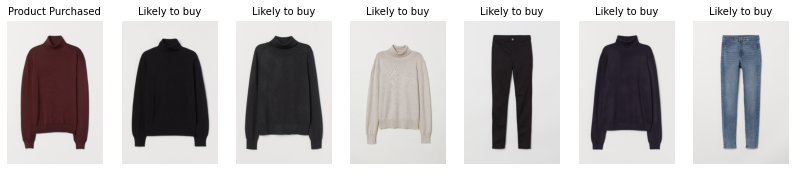

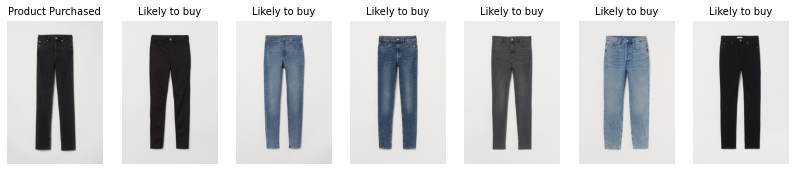

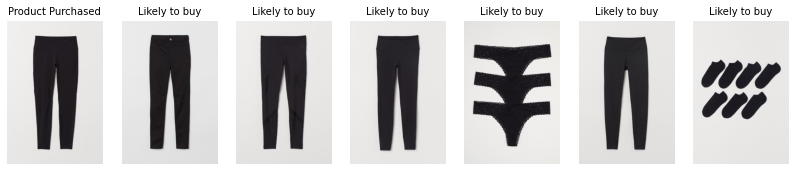

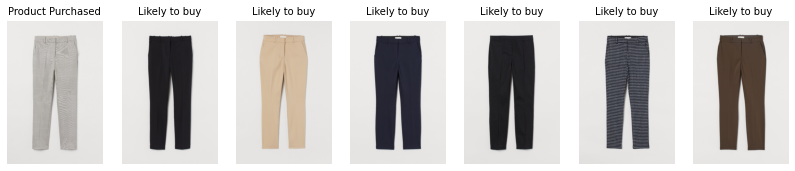

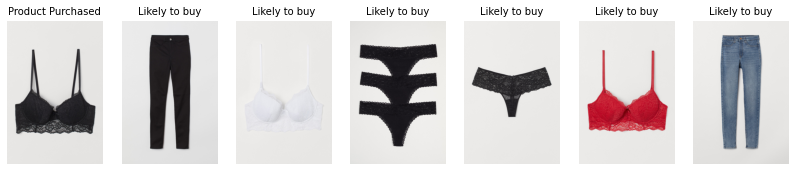

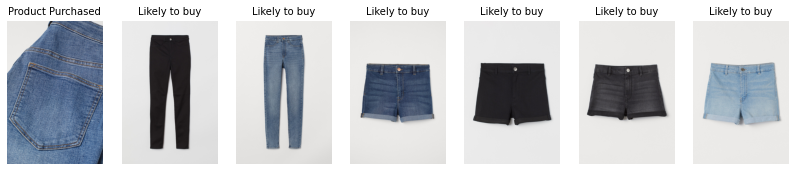

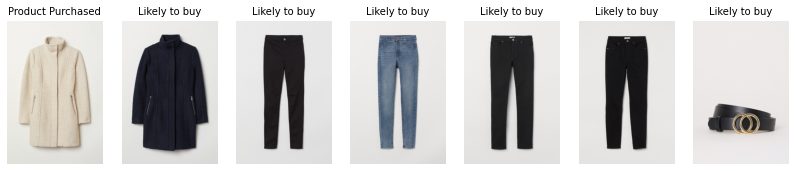

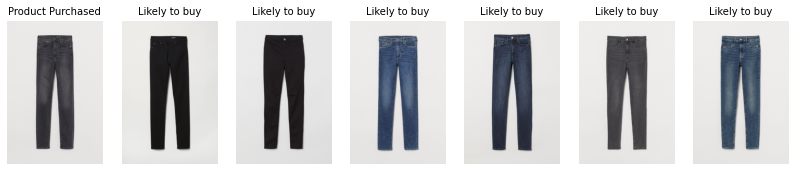

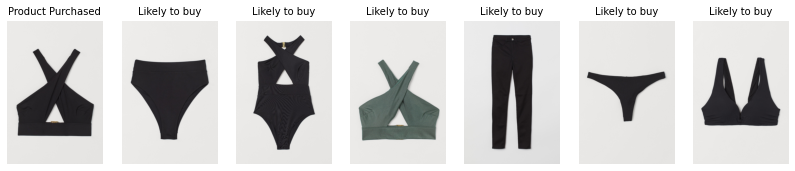

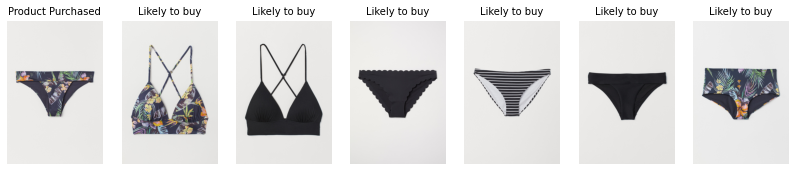

In [ ]:
items = cudf.read_csv('train_C/articles.csv')
BASE = 'train_C/images/'

for i,(k,v) in enumerate(pairs.items()):
    name1 = BASE+'0'+str(k)[:2]+'/0'+str(k)+'.jpg'
    name2 = BASE+'0'+str(v[0])[:2]+'/0'+str(v[0])+'.jpg'
    name3 = BASE+'0'+str(v[1])[:2]+'/0'+str(v[1])+'.jpg'
    name4 = BASE+'0'+str(v[2])[:2]+'/0'+str(v[2])+'.jpg'
    name5 = BASE+'0'+str(v[3])[:2]+'/0'+str(v[3])+'.jpg'
    name6 = BASE+'0'+str(v[4])[:2]+'/0'+str(v[4])+'.jpg'
    name7 = BASE+'0'+str(v[5])[:2]+'/0'+str(v[5])+'.jpg'
    if exists(name1) & exists(name2) & exists(name3) & exists(name4) & exists(name5) & exists(name6) & exists(name7):
        plt.figure(figsize=(14,10))
        img1 = cv2.imread(name1)[:,:,::-1]
        img2 = cv2.imread(name2)[:,:,::-1]
        img3 = cv2.imread(name3)[:,:,::-1]
        img4 = cv2.imread(name4)[:,:,::-1]
        img5 = cv2.imread(name5)[:,:,::-1]
        img6 = cv2.imread(name6)[:,:,::-1]
        img7 = cv2.imread(name7)[:,:,::-1]        
        plt.subplot(1,7,1).axis('off')
        plt.title('Product Purchased',size=10)
        plt.imshow(img1)
        plt.subplot(1,7,2).axis('off')
        plt.title('Likely to buy',size=10)
        plt.imshow(img2)
        plt.subplot(1,7,3).axis('off')
        plt.title('Likely to buy',size=10)
        plt.imshow(img3)
        plt.subplot(1,7,4).axis('off')
        plt.title('Likely to buy',size=10)
        plt.imshow(img4)
        plt.subplot(1,7,5).axis('off')
        plt.title('Likely to buy',size=10)
        plt.imshow(img5)
        plt.subplot(1,7,6).axis('off')
        plt.title('Likely to buy',size=10)
        plt.imshow(img6)
        plt.subplot(1,7,7).axis('off')
        plt.title('Likely to buy',size=10)
        plt.imshow(img7)
        plt.show()
    #if i==63: break


**Inference**

The above model is very interpretable. From the transaction history, we have looked at the pairs of items that have been bought the most. From these pairs, we generate multiple possible combos of articles that a user would be highly likely to purchase.

## **6. Building a Recommender System**

Nowadays, recommender systems are being used in almost every aspect of our lives. Buying groceries online, listening to music, suggestions on websites and even movie recommendations are made using Recommender Systems. We will have a brief look at what these systems comprise of and why this is suited to our dataset.

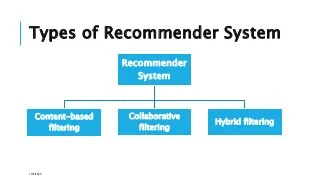

Content-Based recommender system tries to guess the features or behavior of a user given the item’s features, he/she reacts positively to. On the other hand, Colloborative considers other users’ reactions while recommending a particular user. It notes which items a particular user likes and also the items that the users with behavior and likings like him/her likes, to recommend items to that user.

If we use a content based system, it would recommend articles that are similar to the users previous purchases. For example, if a user bought a blue shirt in the past it would recommend a similar blue shirt with a slight variation in pattern. In almost all cases the user would not purchase this recommendation because in the Fashion Industry, things work differently. Hence, we should go with colloborative filtering.

### **Colloborative Filtering**

This technique recommends products to users based on what other users just like them have purchased. The below image explains this clearly.

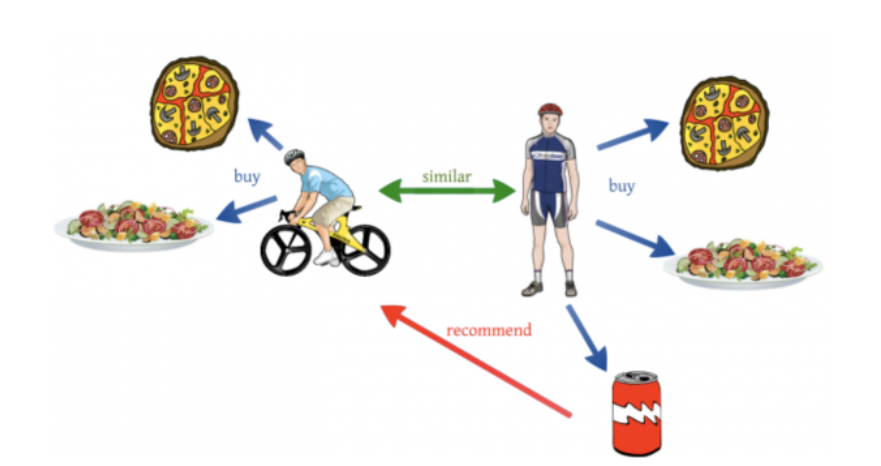

**A**lternating **L**east **S**qaures is one of the most used ML models for recommender systems. It's a matrix factorization method based on SVD. 
Basically, ALS factorizes the interaction matrix (user x items) into two smaller matrices, one for item embeddings and one for user embeddings. These new matrices are built in a manner such that the multiplication of a user and an item gives (approximately) it's interaction score. This build embeddings for items and for users that live in the same vector space, allowing the implementation of recommendations as simple cosine distances between users and items. This is, the 12 items we recommend for a given user are the 12 items with their embedding vectors closer to the user embedding vector.
Source: Wiki

Let us read the input data again..

In [ ]:
df = pd.read_csv('train_C/transactions_train.csv', dtype={'article_id': str}, parse_dates=['t_dat'])
df_sub = pd.read_csv('train_C/sample_submission.csv')
dfu = pd.read_csv('train_C/customers.csv')
dfi = pd.read_csv('train_C/articles.csv', dtype={'article_id': str})

*Sample: Let's subset our transactions data for the last 90 days*

In [ ]:
df = df[df['t_dat'] > '2020-06-20']
df.shape

(4113261, 5)

The next step is to create a User x Item Matrix similar to the one shown in red in the figure below. (Source: [Recommender System with CF](https://https://towardsdatascience.com/mixed-recommender-system-mf-matrix-factorization-with-item-similarity-based-cf-collaborative-544ddcedb330)). After creating this U x I matrix, the aim is to decompose it into two smaller matrices such that their matrix multiplication would be approximately the parent matrix. This is called matrix decomposition.

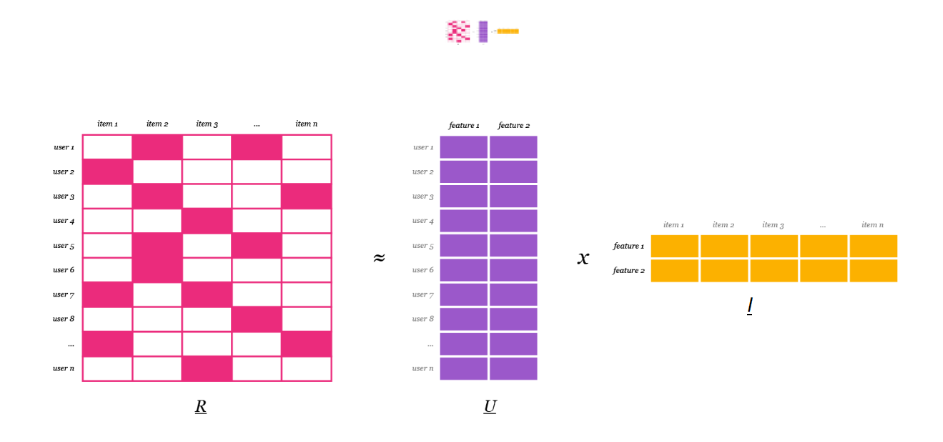

In [ ]:
ALL_USERS = dfu['customer_id'].unique().tolist()
ALL_ITEMS = dfi['article_id'].unique().tolist()

user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

df['user_id'] = df['customer_id'].map(user_map)
df['item_id'] = df['article_id'].map(item_map)

# removing the previously loaded user and item dataframes to free up RAM :-)
del dfu, dfi

#### **Sparse Matrix**: 
 A sparse matrix is a 2D matrix where most of the elements are 0 ie., the numnber of non-zero elements is roughly equal to the columns. Since most of the elements are 0, we can use algorithms to take advantage of this property to save memory. This is one of the reasons why we are going to be able to process 1.37M users and and 105k articles.
*Source: [Wikipedia](https://https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)*

**COO and CSR Matrices:**

**COO** stores a list of (row, column, value) tuples. Ideally, the entries are sorted first by row index and then by column index, to improve random access times. This is another format that is good for incremental matrix construction.
**CSR** It is similar to COO, but compresses the row indices, hence the name. This format allows fast row access and matrix-vector multiplications.
Our customer x article matrix would be sparse given the diverse amount of articles relative to the amount of articles purchased by any customer. We will create a COO sparse matrix and use this for our model.

In [ ]:
row = df['user_id'].values
col = df['item_id'].values
data = np.ones(df.shape[0])
coo_train = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
coo_train

<1371980x105542 sparse matrix of type '<class 'numpy.float64'>'
	with 4113261 stored elements in COOrdinate format>

Taking help from fellow Kaggler Julian for functions that generate COO and CSR matrices from our input matrix. 

In [ ]:
# Creates a items x users sparse matrix
def to_user_item_coo(df):
    row = df['user_id'].values
    col = df['item_id'].values
    data = np.ones(df.shape[0])
    coo = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
    return coo

# Splits a pandas dataframe into train and validation 
def split_data(df, validation_days=7):
    validation_cut = df['t_dat'].max() - pd.Timedelta(validation_days)
    df_train = df[df['t_dat'] < validation_cut]
    df_val = df[df['t_dat'] >= validation_cut]
    return df_train, df_val

# Splits into training and validation and generates CSR and COO matrices
def get_val_matrices(df, validation_days=7):
    df_train, df_val = split_data(df, validation_days=validation_days)
    coo_train = to_user_item_coo(df_train)
    coo_val = to_user_item_coo(df_val)
    csr_train = coo_train.tocsr()
    csr_val = coo_val.tocsr()
    return {'coo_train': coo_train,
            'csr_train': csr_train,
            'csr_val': csr_val
          }

# ALS Model validation function
def validate(matrices, factors=200, iterations=20, regularization=0.01, show_progress=True):
    coo_train, csr_train, csr_val = matrices['coo_train'], matrices['csr_train'], matrices['csr_val']
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    map12 = mean_average_precision_at_k(model, csr_train, csr_val, K=12, show_progress=show_progress, num_threads=4)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@12: {map12:6.5f}")
    return map12

In [ ]:
matrices = get_val_matrices(df)

#### Hyperparamter tuning

For the best hyperparameters, we will iterate over multiple loops to find approximately the best combination. Arbitrarily seleting the factors, iterations and regularization factor, we proceed to see how our model performs.

In [ ]:
best_map12 = 0
for factors in [40, 50, 60, 100, 200, 500, 1000]:
    for iterations in [3, 12, 14, 15, 20]:
        for regularization in [0.01]:
            map12 = validate(matrices, factors, iterations, regularization, show_progress=False)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

Factors:  40 - Iterations:  3 - Regularization: 0.010 ==> MAP@12: 0.00386
Best MAP@12 found. Updating: {'factors': 40, 'iterations': 3, 'regularization': 0.01}
Factors:  40 - Iterations: 12 - Regularization: 0.010 ==> MAP@12: 0.00495
Best MAP@12 found. Updating: {'factors': 40, 'iterations': 12, 'regularization': 0.01}
Factors:  40 - Iterations: 14 - Regularization: 0.010 ==> MAP@12: 0.00493
Factors:  40 - Iterations: 15 - Regularization: 0.010 ==> MAP@12: 0.00493
Factors:  40 - Iterations: 20 - Regularization: 0.010 ==> MAP@12: 0.00492
Factors:  50 - Iterations:  3 - Regularization: 0.010 ==> MAP@12: 0.00391
Factors:  50 - Iterations: 12 - Regularization: 0.010 ==> MAP@12: 0.00541
Best MAP@12 found. Updating: {'factors': 50, 'iterations': 12, 'regularization': 0.01}
Factors:  50 - Iterations: 14 - Regularization: 0.010 ==> MAP@12: 0.00544
Best MAP@12 found. Updating: {'factors': 50, 'iterations': 14, 'regularization': 0.01}
Factors:  50 - Iterations: 15 - Regularization: 0.010 ==> MAP

In [ ]:
coo_train = to_user_item_coo(df)
csr_train = coo_train.tocsr()

Let us define our model function which will train on the best set of parameters we have obtained in the step above.

In [ ]:
def train(coo_train, factors=200, iterations=15, regularization=0.01, show_progress=True):
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=42)
    model.fit(coo_train, show_progress=show_progress)
    return model

The best hyperparameters for our model are:

In [ ]:
best_params

{'factors': 1000, 'iterations': 3, 'regularization': 0.01}

In [ ]:
model = train(coo_train, **best_params)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def submit(model, csr_train, submission_name="submissions.csv"):
    preds = []
    batch_size = 2000
    to_generate = np.arange(len(ALL_USERS))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx : startidx + batch_size]
        ids, scores = model.recommend(batch, csr_train[batch], N=12, filter_already_liked_items=False)
        for i, userid in enumerate(batch):
            customer_id = user_ids[userid]
            user_items = ids[i]
            article_ids = [item_ids[item_id] for item_id in user_items]
            preds.append((customer_id, ' '.join(article_ids)))

    df_preds = pd.DataFrame(preds, columns=['customer_id', 'prediction'])
    df_preds.to_csv(submission_name, index=False)
    
    display(df_preds.head())
    print(df_preds.shape)
    
    return df_preds

The below is our set of predictions for around 1.37M customers on what their next 12 purchases would consist of.

In [ ]:
df_preds = submit(model, csr_train);

customer_id  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...   

                                          prediction  
0  0568601043 0889661001 0770315006 0919741001 08...  
1  0841383002 0850917001 0874113004 0881691003 07...  
2  0794321007 0794321011 0805000001 0740519002 08...  
3  0187949032 0187949031 0187949030 0187949029 01...  
4  0730683050 0896152002 0791587015 0927530004 07...

(1371980, 2)


In [ ]:
# output file to submit to kaggle.
df_preds.to_csv('train_C/output.csv')

## **7. Results, Findings**

#### **Kaggle Submission**


Following is Kaggle's evaluation method

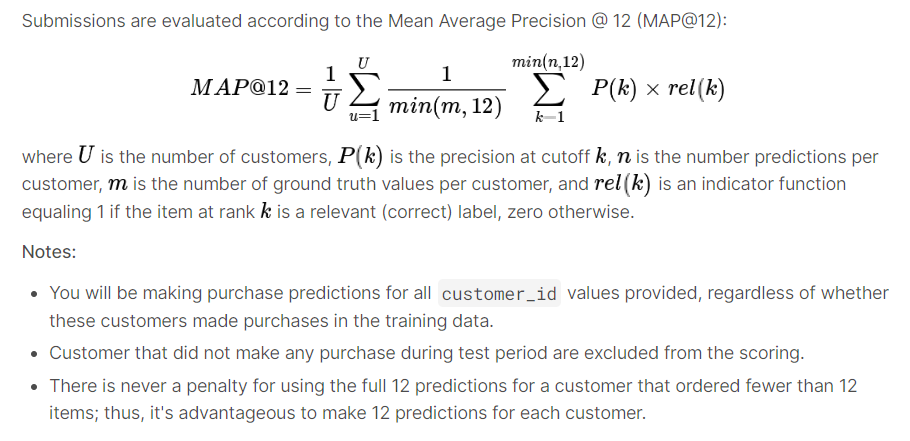

**Our Prediction Score:**

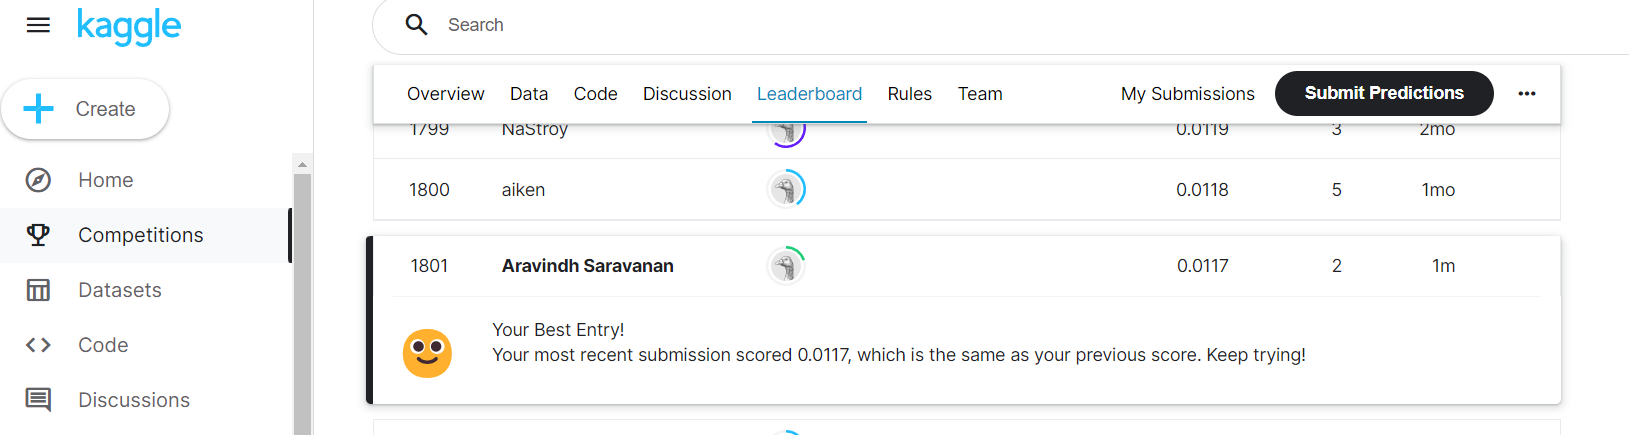

The score for this model is 0.0117 which is decent. At the time of submission, there were around 2500 participating groups.

## **8. Conclusion, Future Work**

Though our ALS model produced decent output, there are a few issues with the above model that need to be addressed. 
1. Training was done on only the last 3 months of transactions. This was done primarily to compensate for the lack of resources  (system memory & processing power)
2. Hyperparamters were selected arbitrarily. Total automatic selection of hyperparameters could lead to better results

Therefore, next steps would be to include the entire training dataset and automate the hyperparameter selection to make it comprehensive.

## **9. Backstage**

There were 3 other major models that were attempted. Both approaches are showcased below
1. Baseline Prediction (simple model)
2. ALS using PySpark
3. Clustering using KModes

### **Baseline Prediction (simple model)**

Looking at the entire range of data

In [ ]:
shape = transactions_train.shape[0]
cust = transactions_train['customer_id'].nunique()
art = transactions_train['article_id'].nunique()
print("No of transactions: "+ str(("{:,}".format(shape)))+ "\nUnique Customers: " + str("{:,}".format(cust)) + "\nUnique Articles: " +  str("{:,}".format(art)))
top_articles = pd.DataFrame(transactions_train.groupby(['article_id'])['customer_id'].count().reset_index(name='count').sort_values(by='count',ascending=False))
top_articles.head(5)

No of transactions: 31,788,324
Unique Customers: 1,362,281
Unique Articles: 104,547


article_id  count
53832   706016001  50287
53833   706016002  35043
1711    372860001  31718
24808   610776002  30199
70124   759871002  26329

How many transactions has each customer made in the entire data?

In [ ]:
cstmr_ordr_cnt = transactions_train.groupby(['customer_id'])['customer_id'].count().reset_index(name='count').sort_values(by=['count'],ascending=False)
cstmr_ordr_cnt.head(10)

customer_id  count
1011710  be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...   1895
962395   b4db5e5259234574edfff958e170fe3a5e13b6f146752c...   1441
391840   49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05...   1364
885174   a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...   1361
1090960  cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed...   1237
456062   55d15396193dfd45836af3a6269a079efea339e875eff4...   1208
1028179  c140410d72a41ee5e2e3ba3d7f5a860f337f1b5e41c27c...   1170
755132   8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d...   1169
20162    03d0011487606c37c1b1ed147fc72f285a50c05f00b971...   1157
578832   6cc121e5cc202d2bf344ffe795002bdbf87178054bcda2...   1143

Let us look at the last 3 months 

In [ ]:
transactions_f = transactions_train[transactions_train['t_dat']>='2020-06-22 00:00:00']
shape = transactions_f.shape[0]
cust = transactions_f['customer_id'].nunique()
art = transactions_f['article_id'].nunique()
print("No of transactions: "+ str(("{:,}".format(shape)))+ "\nUnique Customers: " + str("{:,}".format(cust)) + "\nUnique Articles: " +  str("{:,}".format(art)))
top_articles = pd.DataFrame(transactions_f.groupby(['article_id'])['customer_id'].count().reset_index(name='count').sort_values(by='count',ascending=False))
top_articles.head(5)

No of transactions: 4,056,792
Unique Customers: 535,417
Unique Articles: 42,611


article_id  count
15280   751471001   5912
10287   706016001   5865
569     372860002   4742
961     448509014   4514
4676    610776002   4403

Let us add some more information by joining with article name, type and category 

In [ ]:
temp = pd.merge(transactions_train,articles,how='left',on='article_id')
df = temp[['t_dat', 'customer_id','article_id','price','prod_name','product_type_name','product_group_name']]

In [ ]:
df.head(10)

t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
3 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003   
4 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004   
5 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687001   
6 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221001   
7 2018-09-20  00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...   688873012   
8 2018-09-20  00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...   501323011   
9 2018-09-20  00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...   598859003   

      price                 prod_name product_type_name  product_group_name  
0  0.050831  Atlanta Push Body Harlow    Underwear body           Underwear  
1  0.030492   Rae Push (Melbourne) 2p               Bra           Underwear  
2  0.015237               Inca Jumper           Sweater  Garment Upper body  
3  0.016932      W YODA KNIT OL OFFER           Sweater  Garment Upper body  
4  0.016932      W YODA KNIT OL OFFER           Sweater  Garment Upper body  
5  0.016932      W YODA KNIT OL OFFER           Sweater  Garment Upper body  
6  0.020322               Inca jumper           Sweater  Garment Upper body  
7  0.030492                     Gyda!            Blouse  Garment Upper body  
8  0.053373      Thomas paperbag wide          Trousers  Garment Lower body  
9  0.045746                Fiona Wide          Trousers  Garment Lower body

In [ ]:
df.shape

(31788324, 7)

In [ ]:
x = df['product_type_name'].nunique()
y = df['product_group_name'].nunique()
print("The number of types are: " + str(x) + " and the number of groups: " + str(y))

The number of types are: 130 and the number of groups: 19


In [ ]:
product_type_name_df = df['product_type_name'].value_counts()
product_type_name_df.head(10)

Trousers      4217017
Dress         3238428
Sweater       2783274
T-shirt       2203750
Top           1583408
Blouse        1504868
Vest top      1414101
Bra           1335233
Shorts        1152513
Bikini top    1126202
Name: product_type_name, dtype: int64

In [ ]:
product_group_name_df = df['product_group_name'].value_counts()
product_group_name_df

Garment Upper body       12552755
Garment Lower body        7046054
Garment Full body         3552470
Swimwear                  2579222
Underwear                 2565858
Accessories               1599593
Shoes                      745521
Socks & Tights             685712
Nightwear                  348180
Unknown                     97040
Bags                         7313
Items                        5427
Cosmetic                     1500
Underwear/nightwear           559
Furniture                     533
Garment and Shoe care         279
Stationery                    229
Interior textile               74
Fun                             5
Name: product_group_name, dtype: int64

In [ ]:
cstmr_ordr_cnt.describe()

count
count  1.362281e+06
mean   2.333463e+01
std    3.924225e+01
min    1.000000e+00
25%    3.000000e+00
50%    9.000000e+00
75%    2.700000e+01
max    1.895000e+03

In [ ]:
high_pro_cust = cstmr_ordr_cnt[cstmr_ordr_cnt['count']>=27]
high_pro_cust.shape

(343856, 2)

In [ ]:
top_articles['count'].describe()

count    42611.000000
mean        95.205276
std        238.196352
min          1.000000
25%          3.000000
50%         13.000000
75%         75.000000
max       5912.000000
Name: count, dtype: float64

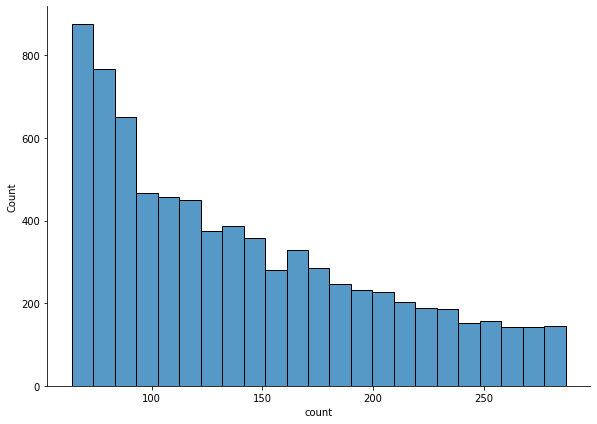

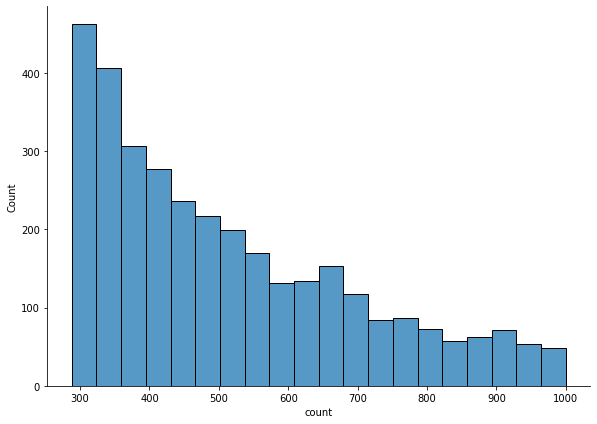

In [ ]:
sns.displot(data=top_articles, x='count',kind='hist', height=6, aspect=1.4, binrange = (64,287))
sns.displot(data=top_articles, x='count',kind='hist', height=6, aspect=1.4, binrange = (288,1000))

In [ ]:
temp = sum(top_articles['count'])
top_articles['bought_percent'] = top_articles['count']/temp*100
top_articles.head(10)

article_id  count  bought_percent
15280   751471001   5912        0.145731
10287   706016001   5865        0.144572
569     372860002   4742        0.116890
961     448509014   4514        0.111270
4676    610776002   4403        0.108534
33455   866383006   4149        0.102273
12644   730683050   4089        0.100794
568     372860001   3931        0.096899
19381   783346001   3915        0.096505
16582   760084003   3801        0.093695

The top 5% of items seem to be the most popular in the 3 month time period. We are going to recommened these to all our customers

In [ ]:
temp = top_articles['count'].quantile(0.95)
sim_recom_articles = top_articles[top_articles['count']>temp]
print("The top 5% consist of "+ str(sim_recom_articles.shape[0])  +" articles " + " and these have been bought at least " + str(int(temp)) + " times")

The top 5% consist of 2128 articles  and these have been bought at least 478 times


In [ ]:
temp = sim_recom_articles['article_id'].reset_index(drop=True)
sim_recom_articles_arr = np.array(temp)

In [ ]:
np.random.choice(sim_recom_articles_arr,12,replace=False)

array([700765001, 509091026, 817477003, 914441001, 837941001, 739144004,
       872537002, 850917003, 881031001, 730683052, 829618004, 659854018])

In [ ]:
customers_list = np.array(customers['customer_id'])
test = np.random.choice(customers_list,10000,replace=False)

In [ ]:
column_names = ["customer_id","article_id"]
recommendations_simple = pd.DataFrame(columns = column_names)
for c in test:
  r = np.random.choice(sim_recom_articles_arr,12,replace=False)
  a = ' '.join(map(str, r))
  recommendations_simple = recommendations_simple.append({'customer_id':c ,'article_id':a},ignore_index=True)

In [ ]:
recommendations_simple.head()

customer_id  \
0  ebfd469a0e4c90b790a409fbb53abe84d020ffa6d39f98...   
1  0098d076aa8b0f96cb364cfe16402f052e00e66ff7aaa5...   
2  b0550090d0f6131e175f771baa7e2f057a8728cdb75bfd...   
3  5341b15a7913a57e94ff934273c47ff85175ed645d1d9a...   
4  1f6c4d9fa70e2d6546c9481566dce0d4b5f33cb8059d94...   

                                          article_id  
0  852584002 871707001 871376002 874754002 842724...  
1  868823008 770315026 860336002 859737002 759871...  
2  881691001 854193001 816832001 800691009 741040...  
3  811835001 562245050 509091026 572797048 906729...  
4  892408008 759482001 673677023 895002004 865468...

### **ALS using PySpark**

##### Setting up PySpark

In [ ]:
import pyspark
from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder.appName("H&M").getOrCreate()

In [ ]:
transactions = (spark.read.format("csv")
                .option("header", "true")
                .load('train_C/transactions_train.csv'))
transactions.printSchema()

root
 |-- t_dat: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- article_id: string (nullable = true)
 |-- price: string (nullable = true)
 |-- sales_channel_id: string (nullable = true)



In [ ]:
from pyspark.sql.functions import *
transactions = transactions.withColumn('t_dat', to_date("t_dat"))

In [ ]:
# find the latests purchase day for every customer
tmp = transactions.groupby("customer_id").agg(
    expr("max(t_dat) AS latest_date")
)

joinExpression = transactions['customer_id'] == tmp["customer_id"]

transactions = transactions.join(tmp, joinExpression).drop(tmp["customer_id"])

In [ ]:
transactions = transactions.withColumn('date_diff', 
                            datediff(col("latest_date"), col("t_dat"))
                                      ).filter("date_diff <= 6")

In [ ]:
tmp = (transactions.groupby("customer_id", "article_id")
                    .count())
tmp.orderBy("count", ascending=False).show(5)

+--------------------+----------+-----+
|         customer_id|article_id|count|
+--------------------+----------+-----+
|18d346ffea696df26...|0719348003|  100|
|f11ddea20db46fd5f...|0557247001|   86|
|1472c551f2c04873e...|0852521001|   81|
|8d70381b62a1d3e6d...|0685813001|   80|
|1c61a6d8aca42d746...|0695545001|   80|
+--------------------+----------+-----+
only showing top 5 rows



In [ ]:
tmp.cache()
tmp.createOrReplaceTempView("tmp")
paired_items = spark.sql("""
    SELECT * FROM
    (SELECT *, row_number() over
    (PARTITION BY customer_id ORDER BY count DESC) as row_index
    FROM tmp) a
    WHERE row_index <= 3
    """)

tmp.unpersist()

DataFrame[customer_id: string, article_id: string, count: bigint]

In [ ]:
paired_items = (paired_items.groupBy('customer_id')
                            .agg(collect_set('article_id')
                            .alias('article_id')))
paired_items.show()

+--------------------+--------------------+
|         customer_id|          article_id|
+--------------------+--------------------+
|000064249685c1155...|[0740962001, 0738...|
|0001ab2ebc1bb9a21...|[0841260012, 0636...|
|00028f80bf6da2c28...|        [0565379002]|
|000346516dd355b40...|[0816423002, 0854...|
|0003e56a4332b2503...|        [0682520002]|
|00047d50bde8751b2...|[0909081004, 0897...|
|00048f2f68760664d...|[0587026012, 0587...|
|00053308738e0d6bc...|        [0589440005]|
|0005baed366933727...|        [0498620002]|
|0005c68366e795568...|[0741356002, 0824...|
|000608ab13228c9d4...|[0659832001, 0756...|
|0006bfcec82c6c132...|[0817354001, 0903...|
|0006ca2c5ecdbdcc1...|[0572998009, 0572...|
|000782c5ed3f985d9...|[0680264001, 0740...|
|00096b1fee245c605...|[0309864010, 0399...|
|000a8f7a2d7822d47...|[0778064005, 0803...|
|000ca60ca6d8de6d3...|        [0781758005]|
|000d6bc779aec5d61...|[0590928011, 0559...|
|000d78086490e983d...|[0744786002, 0744...|
|000dbe324db72b954...|[081693800

In [ ]:
transactions.cache()
transactions.createOrReplaceTempView('transactions')
top12 = spark.sql("""
    SELECT article_id, COUNT(*) count FROM transactions
    WHERE t_dat > '2020-08-23'
    Group BY article_id
    ORDER by count DESC
    Limit 12
    """)

In [ ]:
from pyspark.sql import Row

p_top12 = top12.select('article_id').toPandas()
t12 = ' '.join(p[0] for p in p_top12.to_numpy())
print(t12) 

0751471001 0918292001 0706016001 0751471043 0915526001 0915529003 0448509014 0909370001 0924243001 0918522001 0850917001 0863595006


In [ ]:
tmp.count()

4579865

In [ ]:
tmp =  transactions.withColumn('t_dat', transactions['t_dat'].cast('string'))
tmp = tmp.withColumn('date', from_unixtime(unix_timestamp('t_dat', 'yyyy-MM-dd')))
tmp = tmp.withColumn('year', year(col('date')))
tmp = tmp.withColumn('month', month(col('date')))
tmp = tmp.withColumn('day', date_format(col('date'), "d"))

tmp = tmp[tmp['year'] == 2020]
tmp = tmp[tmp['month'] == 9]
tmp = tmp[tmp['day'] == 22]
transactions.unpersist()

# Prepare the dataset
tmp = tmp.groupby('customer_id', 'article_id').count()
tmp.show(5)

+--------------------+----------+-----+
|         customer_id|article_id|count|
+--------------------+----------+-----+
|aade70be0f152ba59...|0894769004|    1|
|ed64671ed48411008...|0807244002|    2|
|ed64671ed48411008...|0942955004|    1|
|1a38aa46a24c2e1e8...|0895555002|    1|
|1a38aa46a24c2e1e8...|0918603001|    1|
+--------------------+----------+-----+
only showing top 5 rows



In [ ]:
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") 
           for column in list(set(tmp.columns) - set(['count']))]

In [ ]:
import gc
gc.collect()

272

In [ ]:
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(tmp).transform(tmp)

(train, test) = transformed.randomSplit([0.8, 0.2])

In [ ]:
als = ALS(maxIter=5, regParam=0.09, 
          rank=25, userCol="customer_id_index",
          itemCol="article_id_index", ratingCol="count",
          coldStartStrategy="drop", nonnegative=True)

model=als.fit(train)

In [ ]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="count",predictionCol="prediction")
predictions=model.transform(test)
rmse=evaluator.evaluate(predictions)
print("RMSE is equal to : ", str(rmse))

RMSE is equal to :  0.4730092797934823


In [ ]:
 model.recommendForAllUsers(12).show(10)

+-----------------+--------------------+
|customer_id_index|     recommendations|
+-----------------+--------------------+
|                1|[{1661, 2.7940414...|
|               12|[{1661, 2.8649564...|
|               13|[{5040, 3.7821534...|
|               22|[{6383, 5.363302}...|
|               26|[{1661, 3.0327663...|
|               27|[{1661, 3.0113134...|
|               28|[{1661, 2.8939488...|
|               31|[{1661, 2.788566}...|
|               34|[{1661, 2.7550838...|
|               44|[{1661, 3.01165},...|
+-----------------+--------------------+
only showing top 10 rows



In [ ]:
recs = model.recommendForAllUsers(12).toPandas()
recommendations = (recs['recommendations'].apply(pd.Series)
            .merge(recs, right_index = True, left_index = True) # split a Pandas column with lists of tuples into separate columns
            .drop(["recommendations"], axis = 1) # drop the list of tuples
            .melt(id_vars = ['customer_id_index'], value_name = "recommendations") # turn 'recommendation' columns into rows
            .drop("variable", axis = 1)
            .sort_values('customer_id_index')
            .dropna())

recommendations = pd.concat([recommendations['recommendations'].apply(pd.Series), 
                             recommendations['customer_id_index']], axis = 1) # separate article_ids from counts

In [ ]:
recommendations.columns = ['ArticleID_index','count','UserID_index']
transformed_subset = transformed.select('article_id', 'article_id_index', 'customer_id', 'customer_id_index')
transformed_subset = transformed_subset.toPandas()

In [ ]:
# map index to id
article_map = dict(zip(transformed_subset['article_id_index'], transformed_subset['article_id']))
customer_map = dict(zip(transformed_subset['customer_id_index'], transformed_subset['customer_id']))
recommendations['article_id'] = recommendations['ArticleID_index'].map(article_map)
recommendations['customer_id'] = recommendations['UserID_index'].map(customer_map)

In [ ]:
recommendations.reset_index(drop=True, inplace=True)
recommendations = recommendations[['customer_id','article_id']]
recommendations

customer_id  article_id
0       30b6056bacc5f5c9d04b69749c7680031cf6cb2dcea1b5...  0926221002
1       30b6056bacc5f5c9d04b69749c7680031cf6cb2dcea1b5...  0857347002
2       30b6056bacc5f5c9d04b69749c7680031cf6cb2dcea1b5...  0750481010
3       30b6056bacc5f5c9d04b69749c7680031cf6cb2dcea1b5...  0904961003
4       30b6056bacc5f5c9d04b69749c7680031cf6cb2dcea1b5...  0894481001
...                                                   ...         ...
115459  fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...  0894481001
115460  fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...  0702932001
115461  fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...  0502869002
115462  fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...  0904961003
115463  fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...  0926221002

[115464 rows x 2 columns]

In [ ]:
recommendations.groupby(['customer_id'], as_index="False").agg({'article_id': ' '.join})

article_id
customer_id                                                                                          
0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf4...  0904961003 0871638002 0825109005 0297078008 08...
000525e3fe01600d717da8423643a8303390a055c578ed8...  0740213003 0904961001 0876171001 0750481010 05...
0010e8eb18f131e724d6997909af0808adbba057529edb1...  0502869002 0926221002 0871638002 0757971006 05...
001436e2c83cda28548dd668cfc7d621d70d2baf6f6cf06...  0825109005 0502869002 0871638002 0904961003 08...
0026ebdd70715d8fa2befa14dfed317a1ffe5451aba839a...  0886270006 0883808001 0904961001 0886270008 08...
...                                                                                               ...
ffcd5ff3fd5b9ee6b984c143c973fd2697ca141483d381d...  0571048002 0894481001 0904961003 0724905016 07...
ffd4cf2217de4a0a3f9f610cdec334c803692a18af08ac5...  0904961003 0452618001 0750481010 0724905016 08...
fff2282977442e327b45d8c89afde25617d00124d0f9998...  0857347002 0502869002 0894481001 0750481010 09...
fff380805474b287b05cb2a7507b9a013482f7dd0bce0e6...  0894481001 0914133002 0876171001 0904961001 08...
fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e59...  0750481010 0857347002 0757971006 0297078008 06...

[9622 rows x 1 columns]

The above are our recommendations. Running with PySpark meant that our results were not interpretable. 

### **Clustering**

In [ ]:
!pip install kmodes
from kmodes.kmodes import KModes

In [ ]:
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(data_final)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 21622757.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 21622757.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 21622757.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 21622757.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 21622757.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters


KeyboardInterrupt: ignored

In [ ]:
kmode = KModes(n_clusters=3, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(data_final)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 258303, cost: 20220717.0
Run 1, iteration: 2/100, moves: 31011, cost: 20220717.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 190835, cost: 19889369.0
Run 2, iteration: 2/100, moves: 1035, cost: 19889359.0
Run 2, iteration: 3/100, moves: 1, cost: 19889359.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 306572, cost: 19746699.0
Run 3, iteration: 2/100, moves: 17450, cost: 19745815.0
Run 3, iteration: 3/100, moves: 936, cost: 19745526.0
Run 3, iteration: 4/100, moves: 92, cost: 19745526.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 312849, cost: 20008378.0
Run 4, iteration: 2/100, moves: 68890, cost: 19996818.0
Run 4, iteration: 3/100, moves: 1207, cost: 19996818.0
Init: initializ

array([1, 1, 0, ..., 1, 0, 1], dtype=uint16)

In [ ]:
data_final.insert(0, "Cluster", clusters, True)
data_final

Cluster       t_dat  \
3223437         1  2018-12-09   
18301310        1  2019-12-17   
24574315        0  2020-06-12   
7070730         1  2019-03-25   
15003624        2  2019-09-13   
...           ...         ...   
28406762        0  2020-09-10   
26679774        2  2020-07-25   
10421965        1  2019-06-07   
8356485         0  2019-04-24   
17950958        1  2019-12-03   

                                                customer_id  article_id  \
3223437   549a2e2ea59ddd0872bf384a84f02c29b3673571b2bbda...   683596002   
18301310  ab64fb4abf13a50b46b24c8cb98f56aa43d8a299df407f...   790644001   
24574315  f118e67fc023830fdb7fd8efe0c02d10ca4b8f93a1a23a...   797524001   
7070730   d236695f8fd91aca6081d8dc1afde4d7f9599f3f3ba2e5...   710397003   
15003624  de77258ebc4461f81aaec13984c8eb298e027ce7d13d7c...   771338002   
...                                                     ...         ...   
28406762  2829abf8e52b20195397e7b07c716bf31e267b26cd85fd...   923340001   
26679774  063287ca19841f00251c370653cc832c2c975afec87c02...   817477001   
10421965  f0e9c3f9686ed775f7675a7251c50ccc9868a572e75854...   711053004   
8356485   8a39107aa7da0d70f1714c508aa4c787aca5c9154b8b98...   705975001   
17950958  dedbdd5735c7ed870cc0fb017324827a773dd249c9e17d...   789326001   

             price  size              prod_name product_type_name  \
3223437   0.033881     1            Rania Party             Dress   
18301310  0.025407     1       Winona Roll Neck           Sweater   
24574315  0.010068     1  Norman padded softbra               Bra   
7070730   0.025407     1              Mio Dress             Dress   
15003624  0.033881     2            Denize cord             Skirt   
...            ...   ...                    ...               ...   
28406762  0.016932     1               Lion top               Top   
26679774  0.018627     1          Tequila denim            Shorts   
10421965  0.013542     1              Tess Tee.           T-shirt   
8356485   0.016932     1           kayla shorts            Shorts   
17950958  0.042356     2            NORMA SKIRT             Skirt   

          product_group_name graphical_appearance_name  ...  \
3223437    Garment Full body       Glittering/Metallic  ...   
18301310  Garment Upper body       Glittering/Metallic  ...   
24574315           Underwear                     Solid  ...   
7070730    Garment Full body                     Solid  ...   
15003624  Garment Lower body                     Solid  ...   
...                      ...                       ...  ...   
28406762  Garment Upper body                     Solid  ...   
26679774  Garment Lower body                     Denim  ...   
10421965  Garment Upper body                     Solid  ...   
8356485   Garment Lower body           Placement print  ...   
17950958  Garment Lower body                     Solid  ...   

         perceived_colour_master_name          department_name  \
3223437                         Black                  Dresses   
18301310                        Black            Tops Knitwear   
24574315                        Black      Expressive Lingerie   
7070730                          Blue                  Basic 1   
15003624                        White                    Skirt   
...                               ...                      ...   
28406762                        Black             Jersey fancy   
26679774                         Blue                   Shorts   
10421965                        White                  Basic 1   
8356485                         Black  Young Girl Jersey Fancy   
17950958                        Black                   Skirts   

                      index_name index_group_name                section_name  \
3223437                  Divided          Divided          Divided Collection   
18301310                 Divided          Divided          Divided Collection   
24574315        Lingeries/Tights       Ladieswear             Womens Lingerie   
7070730  

**Backstage Conclusion**

All 3 of the above approaches did not produce the best results. The simple model was as good as random guesses, the ALS using PySpark sufferred from poor fitting and clustering was done on too many variables.

## **10. References**

Course on Recommender Systems: https://www.coursera.org/learn/basic-recommender-systems/home/welcome

Recommender Systems:
1. https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
2. https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe
3. https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
4. https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/

PySpark: https://www.kaggle.com/code/sargisiskandaryan/h-m-spark

Frequent Itemsets: https://www.kaggle.com/code/cdeotte/customers-who-bought-this-frequently-buy-this

Python Resources: 
1. https://www.geeksforgeeks.org/
2. https://www.reddit.com/r/Python/
3. https://www.tutorialspoint.com/index.htm
4. https://www.w3schools.com/python/pandas/pandas_dataframes.asp


Questions on Python Code & Troubleshooting: https://stackoverflow.com/

Resources: Google Colab Pro